<a href="https://colab.research.google.com/github/wachira-samuel/wachira-samuel/blob/main/DSA2024_Agricultural_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 0-to-Hero: Deploying an LLM to Production


LLMs are cool and all, Neil & Alessandro. But how can I actually put one into production myself?

We're going to walk through the stages of this notebook, and at the end, you will have a fully functioning deployed LLM website. You can access this on your phone as well -- think of the applications out in the field in realtime!!

1. Imports/setup
2. ngrok
3. huggingface
4. understanding how the model runs
5. building the website
6. Running the website
7. [Bonus] Finetuning


# Step 1: Setup

In [ ]:
!pip install accelerate
!pip install flask
!pip install datasets

import os
import threading

# We will be using flask, a simple python library, as our webserver
from flask import Flask, render_template, send_file, request

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Make an ngrok account

ngrok is a tool that will allow us to get a public link for our application. When we run the Flask app in Colab, we are running it on one of Google's servers, so accessing it through `localhost` is not possible. Instead, we use ngrok, a reverse proxy, to create an internet-accessible way to access the app.

### a) Go to [ngrok.com](https://ngrok.com/)
### b) Click "Sign up for free" and create an account
### c) Verify your email
### d) Go to the [ngrok dashboard](https://dashboard.ngrok.com/get-started/your-authtoken) and copy your Authtoken

<center> 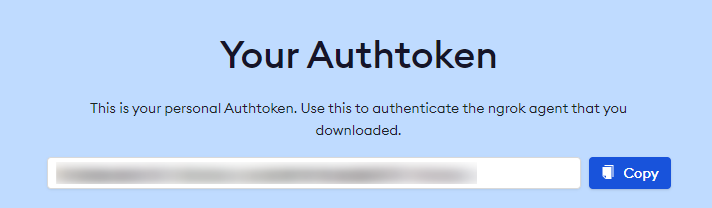</center>

### e) Paste your Authtoken below in place of the existing authtoken (neils) and then **run the cell**

In [ ]:
!pip install pyngrok
from pyngrok import ngrok, conf
conf.get_default().auth_token = '2hMecz5ZMckDn2szGOorMr26FS5_7NKg8wKMUgKMSdFXgW4iK'
# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(5000).public_url
# the first link that prints will be the link to your personal website!
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}/\"".format(public_url, 5000))

 * ngrok tunnel "https://99fe-34-80-107-145.ngrok-free.app" -> "http://127.0.0.1:5000/"


#### RUN THE CELL BELOW THIS FIRST JUST TO GET IT STARTED
# HuggingFace

### What is HuggingFace?
HuggingFace is a large player in the ML space. It's the creator of the transformers library, but more generally an incredible community + resource for all things ML.

### I see a warning: Do we need a huggingface secret token/authentication?
For many models, you will. To save time+bandwidth, we're not going to set this up for this workshop, as TinyLlama doesn't require it. You might get a warning, but its ignorable.

### What is torch?
PyTorch is a machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, originally developed by Meta AI. We're going to be using it for datatypes.
### What is a Huggingface Pipeline?

Pipelines are a great and easy way to use models for inference. These pipelines are objects that abstract most of the complex code from the library, offering a simple API to do things like QuestionAnswer.

### What is text-generation?
It's a type of "Task" an ML model can do -- generate task. Another example could be text-classifcation etc.

### What is device?
you see a weird line down below -- device is basically a way for us to find out if your machine has a GPU, and if so, use it for this pipeline.


## Why are we using TinyLlama?
* One of the important factors we mentioned in our presentations is compute -- cutting edge LLMs are only getting bigger and bigger and require more and more compute to run, let alone train.
* For example, my work Macbook, while only 1-2 years old, takes time to run Llama3-8B. My personal Macbook is absolutely top of the line (M3 Pro, HUGE amount of RAM) and handles Llama3-70B pretty well but still not instant)
* We're seeing a rise in the belief that in the future, tiny, purpose built+trained LLMs will outperform these over time.
* Unfortunately, there was no way for us to guarantee you all access to a GPU.
* TinyLlama will run on the free CPU provided by collab, but it takes on the order of 7 minutes to respond.
* While we wait for those to run, I've actually paid for colab so that we can access a GPU and use bigger models and can still use them much faster so that we can play around with them more!
* On collab you can try to get a GPU for free! Under runtime, select change Runtime type and try to reserve a T4 GPU instance! These are provided for free based on availability!

In [ ]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#model="HuggingFaceH4/zephyr-7b-beta"
model="TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# This next line instantiates
pipe = pipeline("text-generation", model=model, torch_dtype=torch.bfloat16,device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

#### RUN THE CELL BELOW THIS FIRST JUST TO GET IT STARTED

### What is a Chat Template?

Different pipelines and models take input/output differently. Huggingface has helped standarized this with a "chat template" format -- which you see as messages below. It's just a way for the model to get input in a set format, after which it can do whatever it wants with it.

### What is max new tokens?
Size of response

### What are do_sample, temperature, top_k, and top_p?
These are various paramters for the LLMs answer-- we can talk about them, but don't worry about them for this example.

### Where can we edit the system prompt?


Play around with the code below.  
The content under system is the system prompt.
The content under user is your question!

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always speaks like a pirate",
    },
    {"role": "user", "content": "Is there an issue with receiving the right fruit from the coconut plant? I'm curious about any challenges involved?"},
]
asks = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(asks, max_new_tokens=512, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
resp=outputs[0]["generated_text"].split('assistant|>\n')[1]
print(resp)

Yes, receiving the right fruit from the coconut plant can be a challenge, especially for a chatbot that does not have any physical form or senses. Here are some possible issues that chatbots may encounter:

1. Poor quality fruit: The quality of the coconut fruit can vary depending on several factors, including the season, climate, and harvesting methods. A bot may encounter coconuts that are not ripe, moldy, or otherwise unfit for consumption.

2. Miscommunication between the bot and the coconut plant: The coconut plant is a complex organism that can have its own unique needs and behaviors. A bot may not understand the plant's signals or respond appropriately, leading to unexpected outcomes or errors.

3. Poor communication between the bot and humans: The bot may need to communicate with humans to help it understand the plant's needs and requirements. This can involve a series of steps, such as identifying the plant's age, location, and maturity, and translating these into meaningful c

# Basic Web Page Templating
---
CSS File
HTML Template


### But neil, we only have 1 html file. Won't we need 2?
We won't! If we read through the html code, you can see where we can input variables.

Flask has a really useful feature called Templating. This allows us to render different pages without re-writing the whole page.


In [ ]:
import os
if not os.path.isdir('/content/app/'):
  os.mkdir("/content/app/")
os.chdir("/content/app")
if not os.path.isdir('/content/app/static/'):
  os.mkdir("/content/app/static/")

os.chdir("./static")

css = """
    body {
    font-family: Arial, Helvetica, sans-serif;
}

form {
    /* Center the form on the page */
    margin: 0 auto;
    width: 400px;
    /* Form outline */
    padding: 1em;
    display: flex; up
}

img {
    border-radius: 8px;
    display: block;
    margin-left: auto;
    margin-right: auto;
    margin-top: 40px;
    filter: drop-shadow(5px 5px 10px #000);
    opacity: 1;
    hover: opacity: 0.6;
    transition: opacity 1s ease 0s;

}

ul,
li {
    display: inline
}

ul {
    list-style: none;
    padding: 0;
    margin: 0;
    display: flex
}

form li+li {
    margin-top: 1em;
}

label {
    /* Uniform size & alignment */
    display: inline-block;
    width: 90px;
    text-align: right;
}

input,
textarea {
    /* To make sure that all text fields have the same font settings
         By default, textareas have a monospace font */
    font: 1em sans-serif;

    /* Uniform text field size */
    width: 300px;
    box-sizing: border-box;

    /* Match form field borders */
    border: 1px solid #999;
}

input:focus,
textarea:focus {
    /* Additional highlight for focused elements */
    border-color: #000;
}

textarea {
    /* Align multiline text fields with their labels */
    vertical-align: top;

    /* Provide space to type some text */
    height: 5em;
}

.button {
    /* Align buttons with the text fields */
    padding-left: 90px;
    /* same size as the label elements */
}

button {
    /* This extra margin represent roughly the same space as the space
         between the labels and their text fields */
    margin-left: 0.5em;
}

label,
input {
    display: flex;
    flex-direction: column;
}

input,
label {
    display: block;
}"""

with open("styles.css", 'w') as f:
  f.write(css)

os.chdir("..")



os.chdir("/content/app")

html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link rel="stylesheet" type="text/css" href="{{ url_for('static',filename='styles.css') }}" />
    <title>East Africa Agricultural Assistant</title>
      <h1>East Africa Agricultural Assistant</h1>
      <h3>{{question|default("How to easily deploy an LLM onto the internet for your specific usecase",true)}}</h3>
</head>
<body>
    {% autoescape false %}
        {{generated_text}}
    {% endautoescape %}

    <form action="\submit-prompt" method="post" id="submission-form">
        <ul>
            <li>
              <label for="prompt">Prompt:</label>
              <input type="text" id="prompt" name="prompt-input" />
            </li>
            <li class="button">
                <button type="submit">Ask</button>
            </li>
          </ul>
    </form>
</body>
</html>
"""

with open("index.html", 'w') as f:
  f.write(html)




# Goal: Deploy LLM assistant

Flask App Routing
* routes are API endpoints

In [ ]:
import os
import logging

# Set the root directory correctly
os.chdir("/content/app")
app = Flask(__name__,template_folder='.')

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url


# Define Flask routes
@app.route("/")
def initial():
  return render_template('index.html')


@app.route('/submit-prompt', methods=['POST'])
def generate_image():
  prompt = request.form['prompt-input']
  messages = [
      {
          "role": "system",
          "content": "You are a friendly chatbot who always responds in the style of a pirate",
      },
      {"role": "user", "content": prompt},
  ]

  asks = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  outputs = pipe(asks, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
  #getting the users inputted prompt as a variable
  question=outputs[0]["generated_text"].split('user|>\n')[1].split('</s>')[0]

  #getting the response as a variable
  resp=outputs[0]["generated_text"].split('assistant|>\n')[1]

  #reflecting both into the template html
  return render_template('index.html', generated_text=resp.replace("\n"," <br> "), question=question)

# Start the Flask server in a new thread
threading.Thread(target=app.run, kwargs={"use_reloader": False, "debug":True}).start()

# Don't beleive its that short? You can access your chatbot on your phone as well!

### Further Extensions For all of you to think about:
* RAG
* Fine Tuning
* deploying this as an API backing an Android App (Flask can be used for this easily)
* Making the website Multi-Modal! Extend the website: Imagine a farmer submitting a picture of a plant or animal and asking if its sick? Or imagine if a farmer asks for a diagram of how to best plant some specific plant?


Reach out to Alessandro or I:
* https://www.linkedin.com/in/neil123/
* https://www.linkedin.com/in/solbiatialessandro/

# Bonus Section: Fine Tuning OR RAG

There is a dataset in Huggingface that is an Agricultural Q&A dataset. We can use this for finetuning or as a RAG dataset.



In [ ]:
from datasets import load_dataset
dataset = load_dataset("KisanVaani/agriculture-qa-english-only", split="train")
for i in range(10):
    print(f"Datapoint {i + 1}:")
    print("Question:", dataset['question'][i])
    print("Answer:", dataset['answers'][i])
    print("\n")



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Generating train split:   0%|          | 0/22615 [00:00<?, ? examples/s]

Datapoint 1:
Question: why is crop rotation important in farming?
Answer: This helps to prevent soil erosion and depletion, and can also help to control pests and diseases


Datapoint 2:
Question: What farming practice helps prevent soil erosion?
Answer: Crop Rotation


Datapoint 3:
Question: what is crop rotation
Answer: Crop rotation is the practice of growing a series of different crops in the same area over several seasons


Datapoint 4:
Question: what are the different methods of irrigation?
Answer: surface irrigation, drip irrigation, and sprinkler irrigation


Datapoint 5:
Question: why is soil health vital?
Answer: Soil health is critical to crop growth and productivity, as it provides the necessary nutrients and support for plants to thrive.


Datapoint 6:
Question: what are the causes of soil degradation?
Answer: erosion, compaction, and nutrient depletion


Datapoint 7:
Question: what is organic farming?
Answer: method of crop production that emphasizes the use of natural an